In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import decomposition
import seaborn as sns
%matplotlib inline




data = pd.read_csv("C:/Users/KyRun69/Desktop/Cours_Openclassrooms/Projets/Projet_5/CSV/P5_pop.csv")
pop=pd.DataFrame(data)


data1 = pd.read_csv("C:/Users/KyRun69/Desktop/Cours_Openclassrooms/Projets/Projet_5/CSV/P5_dispo_Kcal.csv")
dispo_Kcal=pd.DataFrame(data1)

    
data2 = pd.read_csv("C:/Users/KyRun69/Desktop/Cours_Openclassrooms/Projets/Projet_5/CSV/P5_dispo_prot_animal.csv")
dispo_prot_animal=pd.DataFrame(data2)

data3 = pd.read_csv("C:/Users/KyRun69/Desktop/Cours_Openclassrooms/Projets/Projet_5/CSV/P5_dispo_prot_total.csv")
dispo_prot_total=pd.DataFrame(data3)

In [2]:
  
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    


In [3]:
dispo_Kcal=dispo_Kcal.rename(columns={"Valeur":"dispo_Kcal"})

dispo_prot_total=dispo_prot_total.rename(columns={"Valeur":"dispo_prot_total"})


pop2010=pop[pop.Année==2010]
pop2010=pop2010.reset_index()
#print(pop2010[pop2010["Code Pays"]==151]) 
                        #Le pays "Antilles néerlandaises (ex)" est présent sur le df pop2010 mais pas sur pop2013
    
pop2010=pop2010[pop2010["Code Pays"]!=151]
pop2010=pop2010.reset_index()

pop2013=pop[pop.Année==2013]
pop2013=pop2013.reset_index()

ratio_pop={"ratio":((pop2013.Valeur*1000)/(pop2010.Valeur*1000)*100-100).tolist()}
df_ratio_pop=pd.DataFrame(ratio_pop)



data_4={"Pays":dispo_Kcal.Pays.tolist(),"dispo_Kcal":dispo_Kcal.dispo_Kcal.tolist(),"dispo_prot_total":dispo_prot_total.dispo_prot_total.tolist(),"ratio_pop":df_ratio_pop.ratio.tolist(),"ratio_prot":dispo_prot_animal.Valeur/dispo_prot_total.dispo_prot_total}
df=pd.DataFrame(data_4)

print(df[df.Pays=="Oman"])   #Le pays Oman est un outlier                            
df=df[df.Pays!="Oman"]

print(df[df.Pays=="Soudan"]) #Le pays Soudan est un outlier
df=df[df.Pays!="Soudan"]

df=df.reset_index(drop=True)
df=df.set_index("Pays")

     Pays  dispo_Kcal  dispo_prot_total  ratio_pop  ratio_prot
118  Oman        3143             88.25  29.575455    0.517734
       Pays  dispo_Kcal  dispo_prot_total  ratio_pop  ratio_prot
150  Soudan        2336             70.71 -12.830639    0.412954


In [4]:
print(df.describe())

        dispo_Kcal  dispo_prot_total   ratio_pop  ratio_prot
count   172.000000        172.000000  172.000000  172.000000
mean   2850.209302         81.388314    4.034940    0.426902
std     438.350046         20.082762    3.355160    0.162097
min    1879.000000         37.660000   -2.406941    0.098398
25%    2536.500000         64.225000    1.549030    0.283557
50%    2833.000000         81.595000    3.810925    0.450749
75%    3201.750000         95.290000    6.144401    0.564894
max    3768.000000        133.540000   12.687839    0.730841


In [5]:
i=0
indice= pd.DataFrame(columns=['Indice'])
for i in range(df.index.size) :
    if (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Rien au dessus de la moyenne"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Tout au dessus de la moyenne"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Juste dispo_Kcal"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Juste dispo_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Juste ratio_pop"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Juste ratio_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Ratio_pop et ratio_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Dispo_prot et ratio_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Dispo_Kcal et ratio_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Dispo_prot et ratio_pop"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Dispo_Kcal et ratio_pop"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Dispo_Kcal et dispo_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot<0.56):
       indice=indice.append({"Indice":"Tout sauf ratio_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop<3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Tout sauf ratio_pop"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal>=3200) & (df.iloc[i].dispo_prot_total<81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Tout sauf dispo_prot"}, ignore_index=True)
    elif (df.iloc[i].dispo_Kcal<3200) & (df.iloc[i].dispo_prot_total>=81.595) & (df.iloc[i].ratio_pop>=3.81) & (df.iloc[i].ratio_prot>=0.56):
       indice=indice.append({"Indice":"Tout sauf dispo_Kcal"}, ignore_index=True)
    else :
       indice=indice.append({"Indice":"Autre"}, ignore_index=True)                                                                                                  
                                                                          

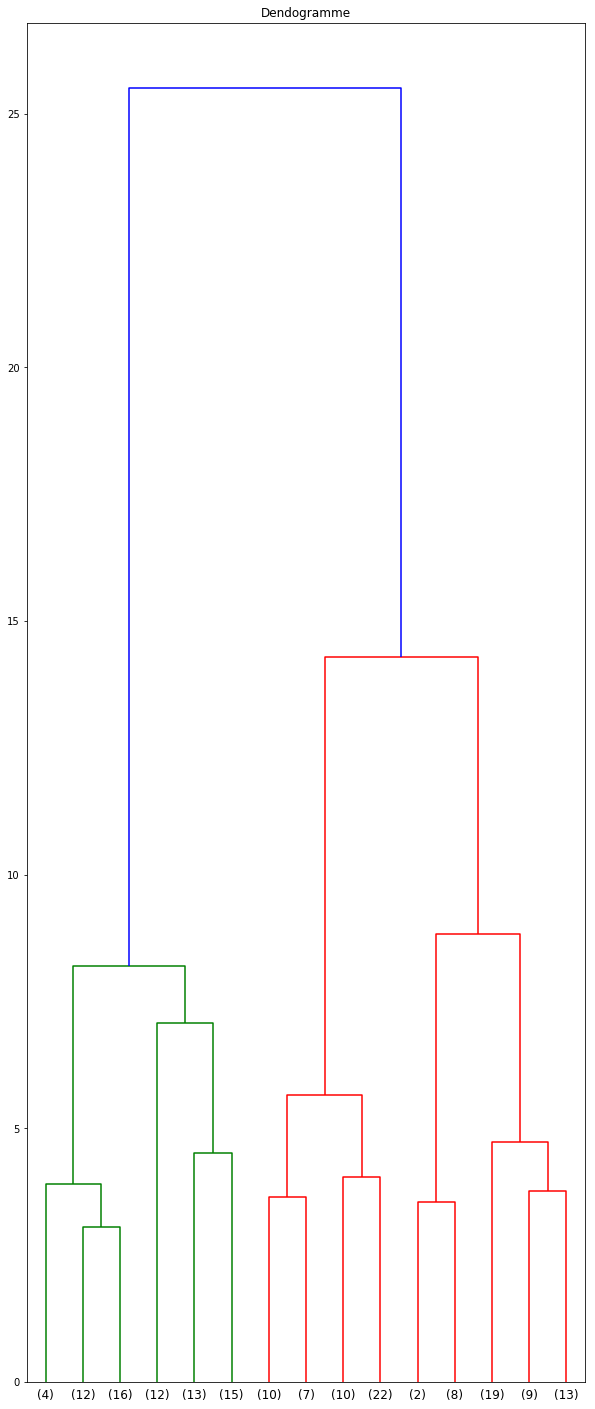

In [6]:
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Dendogramme')
    dendrogram(
        Z,
        #orientation="right",
        labels = names,
        truncate_mode='lastp',
        p=15,  
    )
    plt.show()

# préparation des données pour le clustering
X = df.values
names = df.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

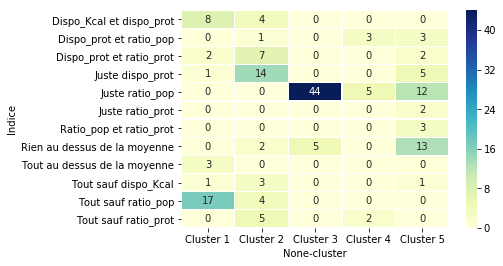

In [7]:
# Découpage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')

# Comparaison des clusters trouvés

courses = pd.DataFrame({"cluster": clusters, "Pays":df.index, "Indice": indice.Indice})

sns.heatmap(courses.pivot_table(index="Indice" , columns="cluster", aggfunc=len, fill_value=0), annot=True, xticklabels=["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"], linewidths=.3, cmap="YlGnBu")

                          dispo_Kcal  dispo_prot_total  ratio_pop  ratio_prot  \
Pays                                                                            
Albanie                         3193            111.42   0.730159    0.533297   
Allemagne                       3499            101.59  -0.349326    0.605178   
Argentine                       3229            102.64   2.655174    0.652182   
Australie                       3276            106.28   4.191216    0.674445   
Autriche                        3768            106.21   1.106879    0.591846   
Belgique                        3733             99.59   1.489809    0.583593   
Canada                          3494            104.95   3.094415    0.521201   
Chine - RAS de Hong-Kong        3290            129.18   2.184397    0.730841   
Danemark                        3367            108.88   1.225005    0.641256   
Espagne                         3174            104.88   1.613183    0.621186   
Estonie                     

C:\Users\KyRun69\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


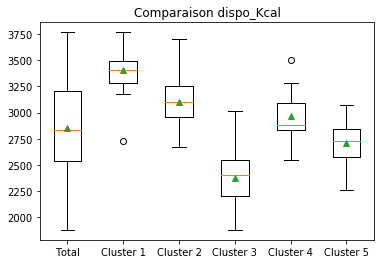

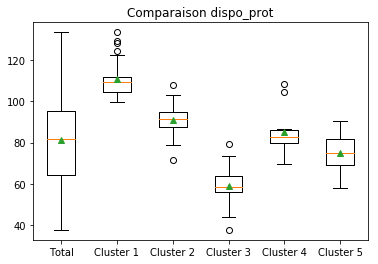

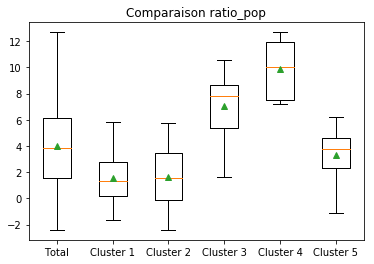

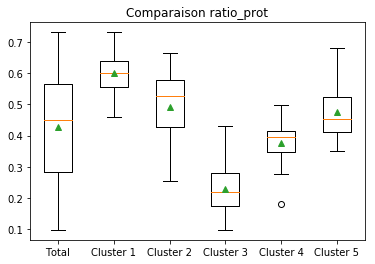

In [8]:
indice["Pays"]=df.index
df=pd.merge(df.reset_index(),indice,how="left")
cluster_1=pd.DataFrame({"Pays":courses.Pays[courses.cluster==1]})
pays_cluster_1=pd.merge(cluster_1,df.reset_index(),how="left")
pays_cluster_1=pays_cluster_1.set_index("Pays")
pays_cluster_1=pays_cluster_1.drop(columns="index")

cluster_2=pd.DataFrame({"Pays":courses.Pays[courses.cluster==2]})
pays_cluster_2=pd.merge(cluster_2,df.reset_index(),how="left")

cluster_3=pd.DataFrame({"Pays":courses.Pays[courses.cluster==3]})
pays_cluster_3=pd.merge(cluster_3,df.reset_index(),how="left")

cluster_4=pd.DataFrame({"Pays":courses.Pays[courses.cluster==4]})
pays_cluster_4=pd.merge(cluster_4,df.reset_index(),how="left")

cluster_5=pd.DataFrame({"Pays":courses.Pays[courses.cluster==5]})
pays_cluster_5=pd.merge(cluster_5,df.reset_index(),how="left")

print(pays_cluster_1)

fig, ax = plt.subplots()
ax.boxplot([df.dispo_Kcal,pays_cluster_1.dispo_Kcal,pays_cluster_2.dispo_Kcal,pays_cluster_3.dispo_Kcal,pays_cluster_4.dispo_Kcal,pays_cluster_5.dispo_Kcal],showmeans=True)
plt.title('Comparaison dispo_Kcal')
plt.gca().xaxis.set_ticklabels(['Total','Cluster 1',"Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5" ])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([df.dispo_prot_total,pays_cluster_1.dispo_prot_total,pays_cluster_2.dispo_prot_total,pays_cluster_3.dispo_prot_total,pays_cluster_4.dispo_prot_total,pays_cluster_5.dispo_prot_total],showmeans=True)
plt.title('Comparaison dispo_prot')
plt.gca().xaxis.set_ticklabels(['Total','Cluster 1',"Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5" ])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([df.ratio_pop,pays_cluster_1.ratio_pop,pays_cluster_2.ratio_pop,pays_cluster_3.ratio_pop,pays_cluster_4.ratio_pop,pays_cluster_5.ratio_pop],showmeans=True)
plt.title('Comparaison ratio_pop')
plt.gca().xaxis.set_ticklabels(['Total','Cluster 1',"Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5" ])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([df.ratio_prot,pays_cluster_1.ratio_prot,pays_cluster_2.ratio_prot,pays_cluster_3.ratio_prot,pays_cluster_4.ratio_prot,pays_cluster_5.ratio_prot],showmeans=True)
plt.title('Comparaison ratio_prot')
plt.gca().xaxis.set_ticklabels(['Total','Cluster 1',"Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5" ])
plt.show()

In [9]:
pays_cluster_1["cluster"]=[1 for i in range(len(pays_cluster_1))]
pays_cluster_2["cluster"]=[2 for i in range(len(pays_cluster_2))]
pays_cluster_3["cluster"]=[3 for i in range(len(pays_cluster_3))]
pays_cluster_4["cluster"]=[4 for i in range(len(pays_cluster_4))]
pays_cluster_5["cluster"]=[5 for i in range(len(pays_cluster_5))]
#print(pays_cluster_2["cluster"])
tous_les_pays=pd.merge(pays_cluster_1.reset_index().drop(columns=['dispo_Kcal','dispo_prot_total','ratio_pop','ratio_prot','Indice']),pays_cluster_2.drop(columns=['dispo_Kcal','dispo_prot_total','ratio_pop','ratio_prot','Indice','index']),how="outer",on=["Pays","cluster"])
tous_les_pays=pd.merge(tous_les_pays,pays_cluster_3.drop(columns=['dispo_Kcal','dispo_prot_total','ratio_pop','ratio_prot','Indice','index']),how="outer",on=["Pays","cluster"])
tous_les_pays=pd.merge(tous_les_pays,pays_cluster_4.drop(columns=['dispo_Kcal','dispo_prot_total','ratio_pop','ratio_prot','Indice','index']),how="outer",on=["Pays","cluster"])
tous_les_pays=pd.merge(tous_les_pays,pays_cluster_5.drop(columns=['dispo_Kcal','dispo_prot_total','ratio_pop','ratio_prot','Indice','index']),how="outer",on=["Pays","cluster"])

pays_cluster_1=pays_cluster_1.drop(columns="cluster")
pays_cluster_2=pays_cluster_2.drop(columns="cluster")
pays_cluster_3=pays_cluster_3.drop(columns="cluster")
pays_cluster_4=pays_cluster_4.drop(columns="cluster")
pays_cluster_5=pays_cluster_5.drop(columns="cluster")

df=pd.merge(df,tous_les_pays,how='left')
print(df)

                                       Pays  dispo_Kcal  dispo_prot_total  \
0                               Afghanistan        2090             58.25   
1                            Afrique du Sud        3022             85.33   
2                                   Albanie        3193            111.42   
3                                   Algérie        3296             91.96   
4                                 Allemagne        3499            101.59   
5                                    Angola        2473             57.26   
6                        Antigua-et-Barbuda        2417             83.71   
7                           Arabie saoudite        3255             91.63   
8                                 Argentine        3229            102.64   
9                                   Arménie        2928             90.04   
10                                Australie        3276            106.28   
11                                 Autriche        3768            106.21   

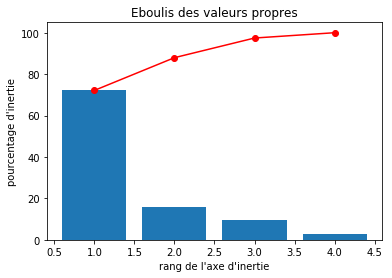

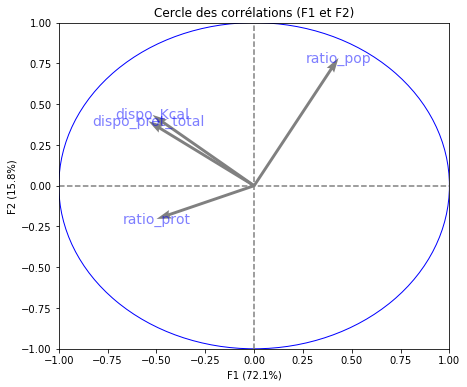

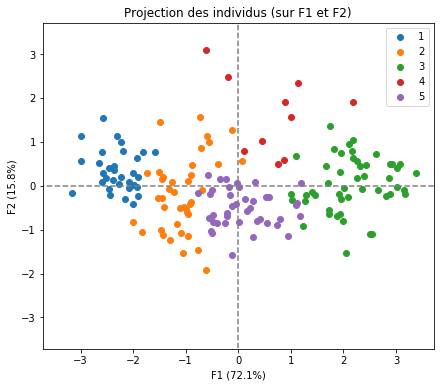

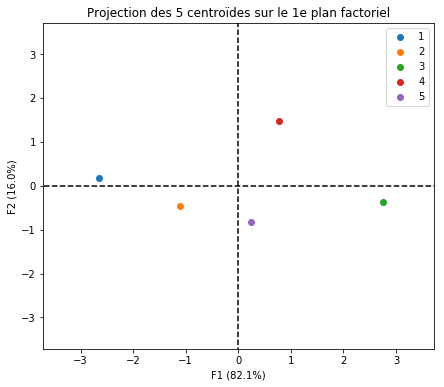

In [10]:
# choix du nombre de composantes à calculer
n_comp = 4

# import de l'échantillon
X = df.drop(columns=["Indice","Pays","cluster"]).values

# Centrage & réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components= n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)


# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)],labels = np.array(df.drop(columns=["Indice","Pays"]).columns))


# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var=df.cluster)


#Projection des centroîdes

X_centroides2 = df.drop(columns=['Pays','Indice'])
X_centroides2= X_centroides2.groupby("cluster").mean()
X_centroides = X_centroides2.values
X_centroides2 = X_centroides2.reset_index()
std_scale = preprocessing.StandardScaler().fit(X_centroides)
X_centroides = std_scale.transform(X_centroides)
pca = decomposition.PCA(n_components= n_comp)
pca.fit(X_centroides)
X_centroides3 = pca.transform(X_centroides)


axis_ranks=[(0,1)]
illustrative_var=X_centroides2.cluster
fig = plt.figure(figsize=(7,6))
for d1,d2 in axis_ranks:
        if d2 < n_comp:
            for value in np.unique(illustrative_var):
                selected = np.where(illustrative_var == value)
                plt.scatter(X_centroides3[selected, d1], X_centroides3[selected, d2], alpha=1, label=value)
                plt.legend()
                
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
                
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
plt.title("Projection des 5 centroïdes sur le 1e plan factoriel")
plt.plot([0.0, 0.0], [-4, 4],"k--")
plt.plot([-4, 4], [0.0,0.0],"k--")
plt.show(block=False)

#On remet tout à 0
X = df.drop(columns=["Indice","Pays","cluster"]).values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca = decomposition.PCA(n_components= n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [11]:
X_centroides4=pd.DataFrame(X_centroides3,columns=["F1","F2","F3","F4"])
X_centroides4["cluster"]=X_centroides2.cluster
mes_centroides=pd.merge(X_centroides2,X_centroides4,how="left")
mes_centroides=mes_centroides.set_index(mes_centroides.cluster,drop="True").drop(columns=["cluster"])
mes_centroides.to_csv("mes_centroides.csv", sep='\t', encoding='utf-8', index = False)

print(mes_centroides)

          dispo_Kcal  dispo_prot_total  ratio_pop  ratio_prot        F1  \
cluster                                                                   
1        3403.031250        110.667500   1.594456    0.600456 -2.642536   
2        3104.750000         90.952000   1.648044    0.491223 -1.114924   
3        2378.142857         58.908367   7.021621    0.230068  2.746913   
4        2967.700000         85.284000   9.856112    0.377294  0.776080   
5        2705.926829         75.121951   3.279141    0.476032  0.234467   

               F2        F3        F4  
cluster                                
1        0.179662 -0.078950 -0.095786  
2       -0.468049 -0.240554  0.113247  
3       -0.362215 -0.245512 -0.056565  
4        1.468492  0.120184  0.035737  
5       -0.817889  0.444833  0.003366  


In [30]:
#contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
print(pd.DataFrame({'id':df.Pays,'Contribution dans l_inertie totale':di}).set_index("id").sort_values(by='Contribution dans l_inertie totale', ascending=False).head(10))
print(pd.DataFrame({'id':df.Pays,'Contribution dans l_inertie totale':di}).set_index("id").sort_values(by='Contribution dans l_inertie totale', ascending=True).head(10))

#qualité de représentation des individus - COS2
cos2 = X_projected**2
for j in range(4):
 cos2[:,j] = cos2[:,j]/di
print("\n",pd.DataFrame({'id':df.Pays,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1],'COS2_1er_plan_factoriel':cos2[:,0]+cos2[:,1]}).set_index("id").sort_values(by='COS2_1er_plan_factoriel',ascending=False).head(10))
print("\n",pd.DataFrame({'id':df.Pays,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1],'COS2_1er_plan_factoriel':cos2[:,0]+cos2[:,1]}).set_index("id").sort_values(by='COS2_1er_plan_factoriel',ascending=True).head(10))

#Contribution aux axes
n=df.shape[0]
eigval = (n-1)/n*pca.explained_variance_
ctr = X_projected**2
for j in range(4):
 ctr[:,j] = ctr[:,j]/(n*eigval[j])

print("\n",1/172)
print("\n",pd.DataFrame({'id':df.Pays,'CTR_F1':ctr[:,0]}).sort_values(by="CTR_F1",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df.Pays,'CTR_F1':ctr[:,0]}).sort_values(by="CTR_F1",ascending=True).set_index("id").head(10))

print("\n",pd.DataFrame({'id':df.Pays,'CTR_F2':ctr[:,1]}).sort_values(by="CTR_F2",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df.Pays,'CTR_F2':ctr[:,1]}).sort_values(by="CTR_F2",ascending=True).set_index("id").head(10))

print("\n",pd.DataFrame({'id':df.Pays,'CTR_F3':ctr[:,2]}).sort_values(by="CTR_F3",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df.Pays,'CTR_F3':ctr[:,2]}).sort_values(by="CTR_F3",ascending=True).set_index("id").head(10))

print("\n",pd.DataFrame({'id':df.Pays,'CTR_F4':ctr[:,3]}).sort_values(by="CTR_F4",ascending=False).set_index("id").head(10))
print("\n",pd.DataFrame({'id':df.Pays,'CTR_F4':ctr[:,3]}).sort_values(by="CTR_F4",ascending=True).set_index("id").head(10))


                          Contribution dans l_inertie totale
id                                                          
Zambie                                             11.905066
Islande                                            11.602863
Koweït                                             10.748100
Lituanie                                           10.561226
Chine - RAS de Hong-Kong                           10.551092
Libéria                                            10.427880
Madagascar                                         10.053566
Ouganda                                             9.992069
Rwanda                                              9.587161
Mozambique                                          9.294506
                Contribution dans l_inertie totale
id                                                
Kirghizistan                              0.050425
Turkménistan                              0.210350
Viet Nam                                  0.244451
Ouzbékistan  

In [13]:
data5 = pd.read_csv("C:/Users/KyRun69/Desktop/Cours_Openclassrooms/Projets/Projet_5/CSV/P5_PIB.csv")
pib_1=pd.DataFrame(data5)
pib_1=pib_1[pib_1["Code zone"]!=151]
pib=pib_1[pib_1["Année"]==2013]
pib=pib.reset_index(drop=True)

pib=pib.rename(columns={"Zone": "Pays","Valeur":"PIB"})
pib=pib.drop(columns=["Code Domaine", "Domaine", "Code zone", "Code Élément", "Élément", "Code Produit", "Produit", "Code année", "Année", "Unité", "Symbole", "Description du Symbole"])

print(pays_cluster_1)
print(pop2013)
print(pib)
pays_cluster_1=pd.merge(pays_cluster_1.reset_index(),pib,how="left")


pop2013=pop2013.rename(columns={"Valeur":"Population"})
pop2013=pop2013.drop(columns=["index","Code Domaine", "Domaine", "Code Pays", "Code Élément", "Élément", "Code Produit", "Produit", "Code Année", "Année", "Unité", "Symbole", "Description du Symbole"])


pays_cluster_1=pd.merge(pays_cluster_1.reset_index(),pop2013,how="left")

                          dispo_Kcal  dispo_prot_total  ratio_pop  ratio_prot  \
Pays                                                                            
Albanie                         3193            111.42   0.730159    0.533297   
Allemagne                       3499            101.59  -0.349326    0.605178   
Argentine                       3229            102.64   2.655174    0.652182   
Australie                       3276            106.28   4.191216    0.674445   
Autriche                        3768            106.21   1.106879    0.591846   
Belgique                        3733             99.59   1.489809    0.583593   
Canada                          3494            104.95   3.094415    0.521201   
Chine - RAS de Hong-Kong        3290            129.18   2.184397    0.730841   
Danemark                        3367            108.88   1.225005    0.641256   
Espagne                         3174            104.88   1.613183    0.621186   
Estonie                     

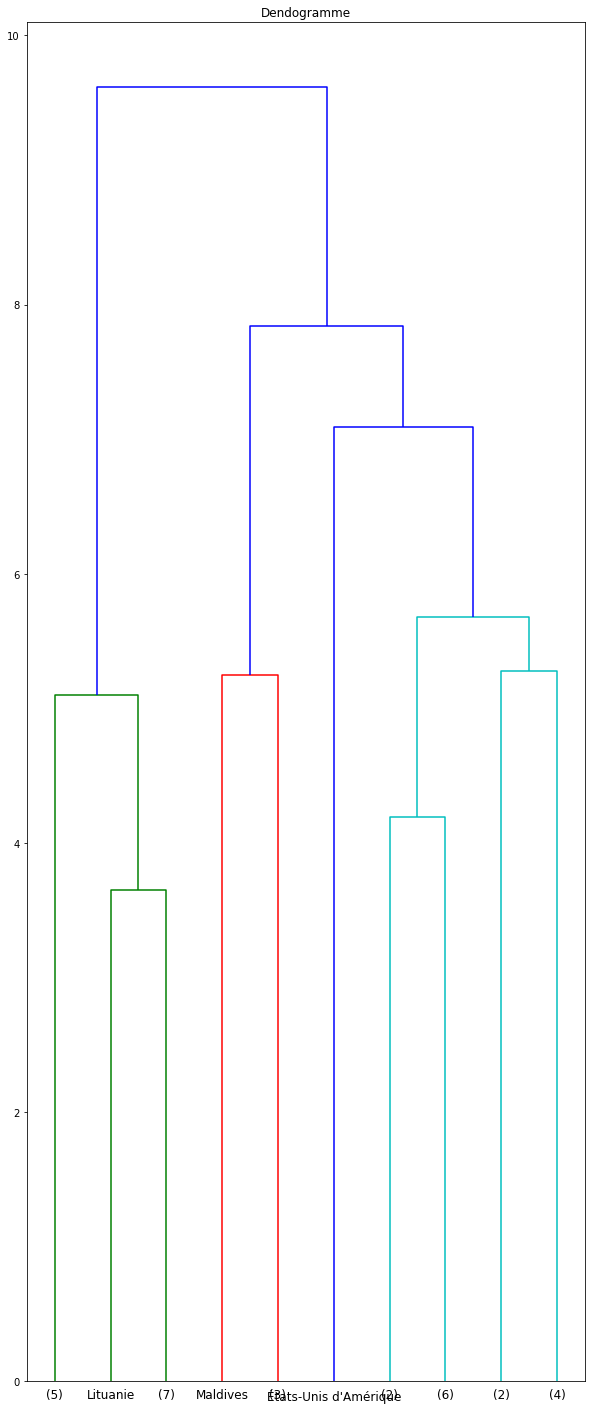

In [14]:
def plot_dendrogram(Z2, names2):
    plt.figure(figsize=(10,25))
    plt.title('Dendogramme')
    dendrogram(
        Z2,
        labels = names2,
        truncate_mode='lastp',
        p=10,  
    )
    plt.show()

# préparation des données pour le clustering
pays_cluster_1=pays_cluster_1.set_index("Pays")

Y = pays_cluster_1.drop(columns="Indice").values
names2 = pays_cluster_1.index


# Centrage et Réduction
std_scale2 = preprocessing.StandardScaler().fit(Y)
Y_scaled = std_scale2.transform(Y)

# Clustering hiérarchique
Z2 = linkage(Y_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z2, names2)

In [15]:
# Coupage du dendrogramme en 3 clusters

clusters2 = fcluster(Z2, 3, criterion='maxclust')

In [16]:
courses2 = pd.DataFrame({"cluster": clusters2, "Pays":pays_cluster_1.index})

cluster2_1=pd.DataFrame({"Pays":courses2.Pays[courses2.cluster==1]})
pays_cluster2_1=pd.merge(cluster2_1,pays_cluster_1.reset_index(),how="left")
#pays_cluster2_1=pays_cluster2_1.drop(columns=["Index"])
                                     
cluster2_2=pd.DataFrame({"Pays":courses2.Pays[courses2.cluster==2]})
pays_cluster2_2=pd.merge(cluster2_2,pays_cluster_1.reset_index(),how="left")
#pays_cluster2_2=pays_cluster2_2.drop(columns=["index"])

cluster2_3=pd.DataFrame({"Pays":courses2.Pays[courses2.cluster==3]})
pays_cluster2_3=pd.merge(cluster2_3,pays_cluster_1.reset_index(),how="left")
#pays_cluster2_3=pays_cluster2_3.drop(columns=["index"])

C:\Users\KyRun69\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


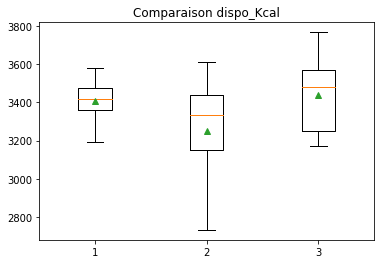

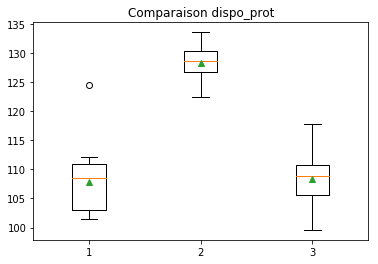

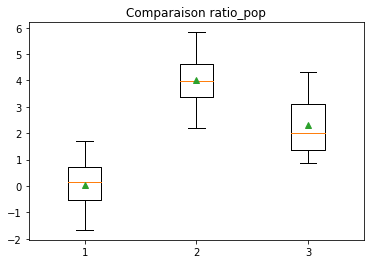

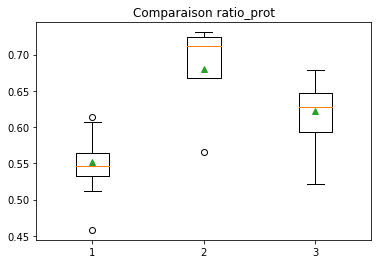

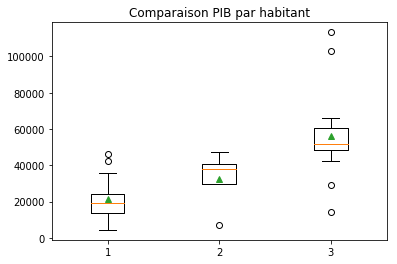

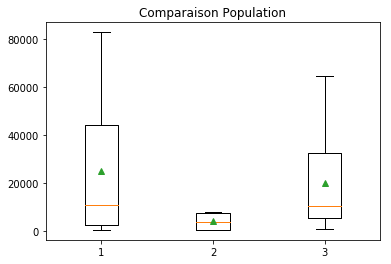

In [17]:
fig, ax = plt.subplots()
ax.boxplot([pays_cluster2_1.dispo_Kcal,pays_cluster2_2.dispo_Kcal,pays_cluster2_3.dispo_Kcal],showmeans=True)
plt.title('Comparaison dispo_Kcal')
plt.gca().xaxis.set_ticklabels(['1',"2", "3"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([pays_cluster2_1.dispo_prot_total,pays_cluster2_2.dispo_prot_total,pays_cluster2_3.dispo_prot_total],showmeans=True)
plt.title('Comparaison dispo_prot')
plt.gca().xaxis.set_ticklabels(['1',"2", "3"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([pays_cluster2_1.ratio_pop,pays_cluster2_2.ratio_pop,pays_cluster2_3.ratio_pop],showmeans=True)
plt.title('Comparaison ratio_pop')
plt.gca().xaxis.set_ticklabels(['1',"2", "3"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([pays_cluster2_1.ratio_prot,pays_cluster2_2.ratio_prot,pays_cluster2_3.ratio_prot],showmeans=True)
plt.title('Comparaison ratio_prot')
plt.gca().xaxis.set_ticklabels(['1',"2", "3"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([pays_cluster2_1.PIB,pays_cluster2_2.PIB,pays_cluster2_3.PIB],showmeans=True)
plt.title('Comparaison PIB par habitant')
plt.gca().xaxis.set_ticklabels(['1',"2", "3"])
plt.show()


fig, ax = plt.subplots()
ax.boxplot([pays_cluster2_1[pays_cluster2_1.Pays!="Fédération de Russie"].Population,pays_cluster2_2.Population, pays_cluster2_3[pays_cluster2_3.Pays!="États-Unis d'Amérique"].Population],showmeans=True)
plt.title('Comparaison Population')
plt.gca().xaxis.set_ticklabels(['1',"2", "3"])
plt.show()

<function matplotlib.pyplot.show>

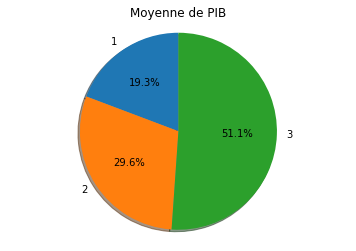

In [18]:
A=[pays_cluster2_1.PIB.mean(), pays_cluster2_2.PIB.mean(), pays_cluster2_3.PIB.mean()]

plt.pie(A,labels=[1,2,3], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Moyenne de PIB")
plt.savefig('PieChart01.png')
plt.show

<function matplotlib.pyplot.show>

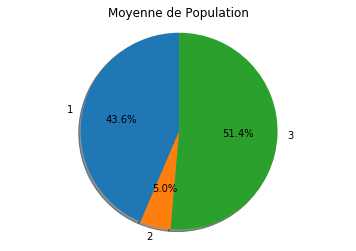

In [19]:
B=[pays_cluster2_1.Population.mean(),pays_cluster2_2.Population.mean(), pays_cluster2_3.Population.mean()]

plt.pie(B,labels=[1,2,3], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Moyenne de Population")
plt.savefig('PieChart01.png')
plt.show

In [20]:
#Choix du cluster 3
print(pays_cluster2_3.Pays)

0                 Argentine
1                 Australie
2                  Autriche
3                  Belgique
4                    Canada
5                  Danemark
6                   Espagne
7     États-Unis d'Amérique
8                  Finlande
9                    France
10                  Irlande
11               Luxembourg
12                  Norvège
13                 Pays-Bas
14                    Suède
Name: Pays, dtype: object


In [21]:
#print(pays_cluster2_3.set_index(pays_cluster2_3.Pays).Population.sort_values(ascending=False))
score_1=pd.DataFrame({'Pays':pays_cluster2_3.Pays,'Population':pays_cluster2_3.Population}).sort_values(by="Population",ascending=False)
score_1["score1"]=[15-i for i in range(15)]
score_2=pd.DataFrame({'Pays':pays_cluster2_3.Pays,'PIB':pays_cluster2_3.PIB}).sort_values(by="PIB",ascending=False)
score_2["score2"]=[15-i for i in range(15)]
score_total=pd.merge(score_1,score_2,how="left")
score_total["total"]=score_total.score1+score_total.score2
print(score_total.sort_values(by="total",ascending=False))

                     Pays  Population  score1            PIB  score2  total
0   États-Unis d'Amérique      320051      15   52898.817379      10     25
5               Australie       23343      10   66301.306788      13     23
4                  Canada       35182      11   52264.959967       9     20
8                   Suède        9571       7   60190.029595      11     18
1                  France       64291      14   42493.606628       3     17
6                Pays-Bas       16759       9   51466.478134       8     17
10               Danemark        5619       5   60942.805627      12     17
12                Norvège        5043       3  103110.441896      14     17
14             Luxembourg         530       1  113341.237463      15     16
2                 Espagne       46927      13   29163.288417       2     15
3               Argentine       41446      12   14417.421454       1     13
7                Belgique       11104       8   46713.462219       4     12
9           

In [22]:
# Mes 4 pays : Suède, Pays-Bas, Danemark et Norvège

mon_choix=pd.DataFrame([["Cluster 1","Cluster 3"],["Cluster 1","Cluster 3"],["Cluster 1","Cluster 3"],["Cluster 1","Cluster 3"]],index=["Suède","Pays-bas","Danemark","Norvège"],columns=["Première classification","Deuxième classification"])
mon_choix.to_csv("mon_choix.csv", sep='\t', encoding='utf-8', index = False)
print(mon_choix)

         Première classification Deuxième classification
Suède                  Cluster 1               Cluster 3
Pays-bas               Cluster 1               Cluster 3
Danemark               Cluster 1               Cluster 3
Norvège                Cluster 1               Cluster 3


In [23]:
from scipy.stats import kstest

#Hypothèse H0 : la disponibilité en Kcal suit une distribution gaussienne

print(kstest(X_scaled[:,0],'norm'))

#La p-value est supérieure au seuil de 5%. L'hypothèse H0 n'est ainsi pas rejetté.
#La distribution du ratio de protéines est donc gaussienne

KstestResult(statistic=0.05819703271366561, pvalue=0.6004195326847048)


In [24]:
cluster_1_scaled = std_scale.transform(pays_cluster_1.drop(columns=["index","Indice",'PIB','Population']).values)
cluster_2_scaled = std_scale.transform(pays_cluster_2.drop(columns=["Pays","index","Indice"]).values)

In [25]:
#Hypothèse H0 : les deux clusters suivent la même loie de distribution pour la disponibilité en Kcal
from scipy.stats import bartlett
bartlett(cluster_1_scaled[:,0],cluster_2_scaled[:,0])
#La p-value est supérieure au seuil de 5%. On ne rejette donc pas l’égalité des variances.

BartlettResult(statistic=0.7266592689821892, pvalue=0.39396819736177313)

In [26]:
from scipy.stats import ttest_ind
ttest_ind(cluster_1_scaled[:,0],cluster_2_scaled[:,0], equal_var=True)
# La p-value est bien inférieure au seuil de 5%. On rejette l'hypothèse H0. 
#les deux clusters ne suivent pas la même loie de distribution pour la disponibilité en Kcal

Ttest_indResult(statistic=5.823178675834855, pvalue=1.6026269596095416e-07)